The first thing we need to do is connect to the MySQL database.

In [122]:
#instantiate mysql connection and cursor
import mysql.connector
cnx = mysql.connector.connect(user='root', 
                              password='password', 
                              host = '127.0.0.1', 
                              database='data')

So provided that doesn't throw errors, let's load a query into Pandas to play with. I'm importing Pandas and Matplotlib to start with, with Seaborn for formatting and styling graphics. This query just pulls the unified view from question 1 in Instructions.md.

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

query = '''SELECT * FROM unified_view'''
df = pd.read_sql_query(query, cnx)

The code below just makes it so that any graphs appear in a nice big form, right in the Notebook.

In [124]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


So now that that's done, let's take a peek into our new dataframe. Looking at the data contained therein in its raw form can help us formulate useful questions.

In [125]:
df.head(n=6)

,company_id,user_id,joined_date,is_admin,location_id,order_id,order_datetime,delivery_date,status,auto_order,source,restaurant_name,name,temperature,value,subsidy
0,8752,145254.0,2015-11-05,0,18424.0,7708972.0,2016-12-29 10:04:00,2017-01-05,fulfilled,0.0,web,La Sen,Vegetable Vermicelli,cold\r,vegan,Full Company Paid
1,8752,149321.0,2015-12-07,0,29341.0,7709386.0,2016-12-29 11:40:00,2017-01-05,user_cancelled,0.0,web,La Sen,Vegetable Vermicelli,cold\r,vegan,Full Company Paid
2,6520,144562.0,2015-11-02,0,18589.0,7709647.0,2016-12-29 12:29:00,2017-01-05,fulfilled,0.0,web,La Sen,Vegetable Vermicelli,cold\r,vegan,Full Company Paid
3,6520,43720.0,2013-07-18,0,18589.0,7714011.0,2016-12-31 20:27:00,2017-01-05,fulfilled,0.0,android,La Sen,Vegetable Vermicelli,cold\r,vegan,Full Company Paid
4,6520,26421.0,2013-01-09,0,18589.0,7714243.0,2017-01-01 08:48:00,2017-01-05,fulfilled,0.0,ios,La Sen,Vegetable Vermicelli,cold\r,vegan,Full Company Paid
5,6520,55647.0,2013-11-06,0,18589.0,7714575.0,2017-01-01 13:03:00,2017-01-05,fulfilled,0.0,ios,La Sen,Vegetable Vermicelli,cold\r,vegan,Full Company Paid


Okay, so it looks like there might be a few interesting things to come out of this data set. 
- The Value field from the Tags table can give us information about food allergies and preferences per order or user, to make quick suggestions to users about what they may like. 
- We can look at trends in the Source field to see what platforms are growing or shrinking in popularity over time.
- We can also find out if there are any specific trends in which restaurants have the most orders - and which dishes from each restaurant are most often ordered. We could even correlate tag frequency with different dishes.
- It may also be interesting to look at which companies use subsidies most often.
- Lastly, we could look at order cancellations and how often those happen.

I'm going to look first at the time-series graphs, namely the trends in the source field and order cancellations.

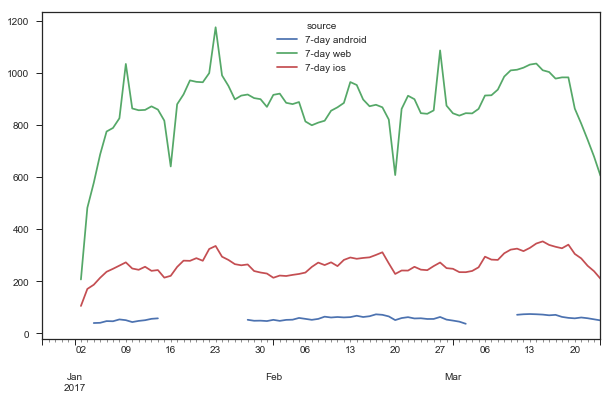

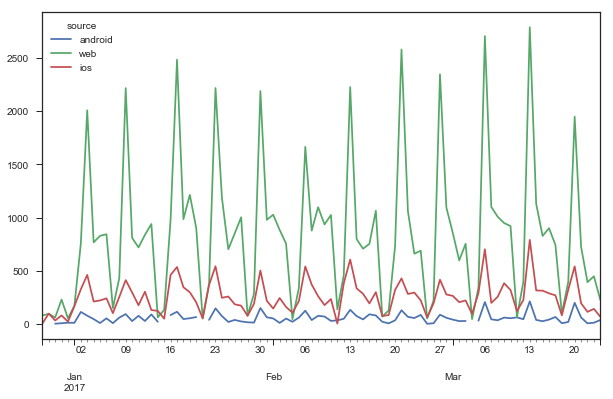

In [128]:
#make easy-to-use table grouped by order datetime and source for time series source trend
plot_df = df.copy()
plot_df['order_date'] = df['order_datetime'].apply(lambda x: x.date())
plot_df = plot_df.groupby(['order_date', 'source'])['order_id'].count()
plot_df = plot_df.unstack('source')
plot_df.index = pd.PeriodIndex(plot_df.index.tolist(), freq='D')

#create rolling means for data smoothing
#creates a 7-day rolling average per source
plot_df['7-day android'] = plot_df['android'].rolling(window=7, center=False).mean()
plot_df['7-day web'] = plot_df['web'].rolling(window=7, center=False).mean()
plot_df['7-day ios'] = plot_df['ios'].rolling(window=7, center=False).mean()


plot_df['28-day android'] = plot_df['android'].rolling(window=28, center=False).mean()
plot_df['28-day web'] = plot_df['web'].rolling(window=28, center=False).mean()
plot_df['28-day ios'] = plot_df['ios'].rolling(window=28, center=False).mean()

#setting the seaborn style to be easier to read
sb.set_style('white')
sb.set_style('ticks')
sb.despine()

#creating the line graphs
plot_df[['7-day android', '7-day web', '7-day ios']].plot()
plot_df[['android', 'web', 'ios']].plot()


It doesn't appear that there is a clear growth trend in ordering source- consistently, most orders are made on web, with iOS the second-most-popular choice and Android coming in last.

Unsurprisingly, it appears people don't make in on weekends nearly as often. People also tend to put in more orders near the middle-end of the month, usually on Monday of the third week of the month.

There were also significant ordering troughs on Martin Luther King Day (January 15) and Presidents' Day (Feb 20)- also unsurprising, since they're bank holidays- with peaks on January 9th, January 24th, and February 28th. It's unclear why those days are peaked. If I had to guess, the 9th is because people were coming  back from vacation, and the 24th and 29th are probably due to some kind of monthly ordering reminder.

Lastly, there is a somewhat concerning downward slope at the end of March on the longterm trends graph. I suspect it is because of lack of data propagation, however this is something to look into. If it *is* a lack of data propagation, I suggest checking pipelines to make sure no data is being dumped. If it is *not* a lack of data propagation, perhaps there is a way to find out via user behavior why fewer orders were put in the last week of March.

Total Cancellations: 10328
Cancellations Summary Statistics 
count     88.000000
mean     117.363636
std       79.316793
min        3.000000
25%       56.000000
50%      115.000000
75%      156.250000
max      408.000000
Name: user_cancelled, dtype: float64

Total Fulfilled: 90268
Delivered Summary Statistics 
count      88.000000
mean     1025.772727
std       791.726670
min        81.000000
25%       446.250000
50%       945.000000
75%      1214.750000
max      3556.000000
Name: fulfilled, dtype: float64


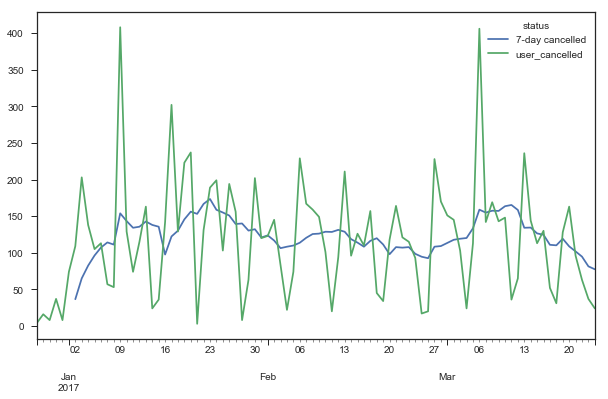

In [129]:
#make easy-to-use table grouped by order datetime and status for time series source trend
status_df = df.copy()
status_df['order_date'] = status_df['order_datetime'].apply(lambda x: x.date())
status_df = status_df.groupby(['order_date', 'status'])['order_id'].count()
status_df = status_df.unstack('status')
status_df.index = pd.PeriodIndex(plot_df.index.tolist(), freq='D')

#create rolling means for data smoothing
#creates a 7-day rolling average of fulfilled and cancelled orders
status_df['7-day cancelled'] = status_df['user_cancelled'].rolling(window=7, center=False).mean()

#setting the seaborn style to be easier to read
sb.set_style('white')
sb.set_style('ticks')
sb.despine()

#creating the line graphs
status_df[['7-day cancelled', 'user_cancelled']].plot()
print "Total Cancellations:", status_df['user_cancelled'].sum()
print "Cancellations Summary Statistics \n", status_df['user_cancelled'].describe()
print "\nTotal Fulfilled:", status_df['fulfilled'].sum()
print "Delivered Summary Statistics \n", status_df['fulfilled'].describe()


It appears that cancellations are pretty constant and don't show a growth trend, which is a good thing. What's not good is that it looks like about about 10% of orders get cancelled. That's a lot. So let's take a deeper look into which orders get cancelled. If we go back to the source data, we can get a couple ideas on how to figure out which orders get cancelled and, maybe, why. 

If we find out which companies tend to make the cancellations, we could send them a survey asking why they do it so often- this would help EAT Club avoid cancellations.

In [148]:
company_status = df.copy()
company_status = company_status.groupby(['company_id', 'status'])['order_id'].count()
company_status = company_status.unstack('status')

company_status['total_orders'] = company_status['user_cancelled'].add(company_status['fulfilled'])
company_status['pct_cancelled'] = 100*(company_status['user_cancelled']/company_status['total_orders'])

company_status.sort_values(['pct_cancelled'], ascending=False)
company_status

status,fulfilled,user_cancelled,total_orders,pct_cancelled
company_id,,,,
6520,35913.0,3561.0,39474.0,9.021128
8752,36071.0,4592.0,40663.0,11.292821
9912,6574.0,886.0,7460.0,11.876676
11471,11672.0,1289.0,12961.0,9.945220
13159,38.0,NaN,NaN,NaN


So, it appears that four out of ten companies are responsible for all of the order cancellations in this data set. The numbers here look kind of wonky because, in the unified view, they are granulated by each user who receives the order- in reality, there are 1991 total cancelled orders in this dataset. However, the four company IDs are, in fact, responsible for all of the cancellations.

I would recommend sending a survey asking these four companies why they tend to cancel orders when the six other companies represented in the dataset do not.

Next, let's take a look at the tags our users typically put on their orders. This can be implemented within the ordering interface to predict how they tend to prefer their meals, and potentially make suggestions.

The cell below creates a table that gives each restaurant's name, the names of specific dishes, and the tags paired with the frequency used per dish. For example, from this table we can see that Alicia's Tamales Beef Tamales are often paired with the tags "gluten_free", "pork_free", "shellfish_free", and "treenut_free". This provides something with which we can look up dishes with a desired tag.

In [178]:
tags = df.copy()
tags = tags.groupby(['restaurant_name', 'name', 'value'])['user_id'].count()
tags.sort_values()
tags.head(n=15)

restaurant_name         name                    value         
Alicia's Tamales - Hot  Beef Tamales            gluten_free        6
                                                pork_free          6
                                                shellfish_free     6
                                                treenut_free       6
                        Mole Poblano Chicken    chicken           41
                                                hot               41
                                                mexican           41
                        Pork Tamales            shellfish_free    77
                                                treenut_free      77
Arigato Tokyo           Chashu Pork Miso Ramen  asian             65
                                                hot               65
                                                pork              65
                                                shellfish_free    65
                                        

Let's say I'm allergic to shellfish and want to find all dishes within EAT Club's database that don't have shellfish. We can now use the Tags table to find all of the dishes in any restaurant which are tagged "shellfish_free." Not only that, but say my company is putting an order into Cantina Francisco today, so I need a dish from Cantina that I won't be allergic to.

In [192]:
tags.xs(("Cantina Francisco","shellfish_free"), level=('restaurant_name','value'))

name
Bean & 3 Cheese Burrito                8
Bean & 3 Cheese Wet Burrito           22
Beef Short Rib Burrito Bowl            8
Blue Corn Tamale with Green Chile    116
Carnitas Burrito                       6
Carnitas Burrito Bowl                 15
Chicken Burrito                       14
Chicken Burrito Bowl                  19
Chicken Wet Burrito                    9
Chile Verde Beef                      42
Chile Verde Pork                      88
Green Chile Tamale                    81
Ranchero Beef                        119
Ranchero Pork                         61
Name: user_id, dtype: int64

Cool, so now we have a list of things I can eat - and how many users have ordered this food with this tag. This type of data manipulation can be used to make suggestions to users based on the type of tags they typically have associated with their orders. If you do not already, EAT Club can implement this as a delightful feature for people that don't want to have to sort through a menu every time they order lunch.

But is user behavior predictable? Let's look and see:

['7-day american', '7-day asian', '7-day beef', '7-day chicken', '7-day cold', '7-day contains_nuts', '7-day dairy_free', '7-day entree', '7-day fish', '7-day fusion', '7-day gluten_free', '7-day hot', '7-day indian', '7-day italian', '7-day mexican', '7-day paleo', '7-day poke', '7-day pork', '7-day pork_free', '7-day salad', '7-day shellfish', '7-day shellfish_free', '7-day soup', '7-day soup_salad', '7-day spicy', '7-day treenut_free', '7-day turkey', '7-day vegan', '7-day vegetarian']


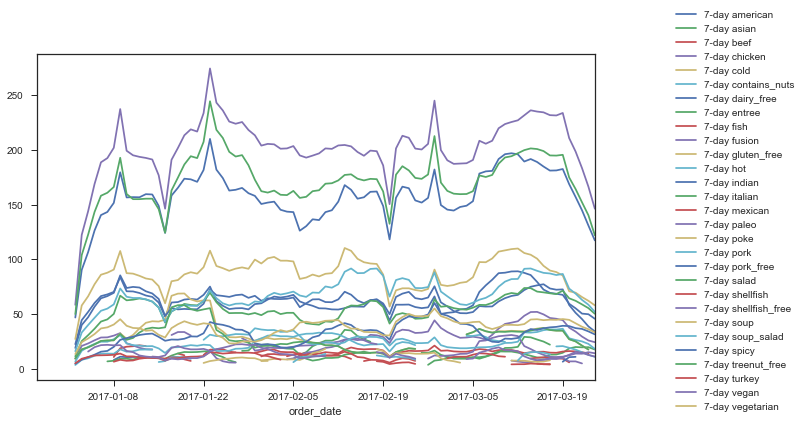

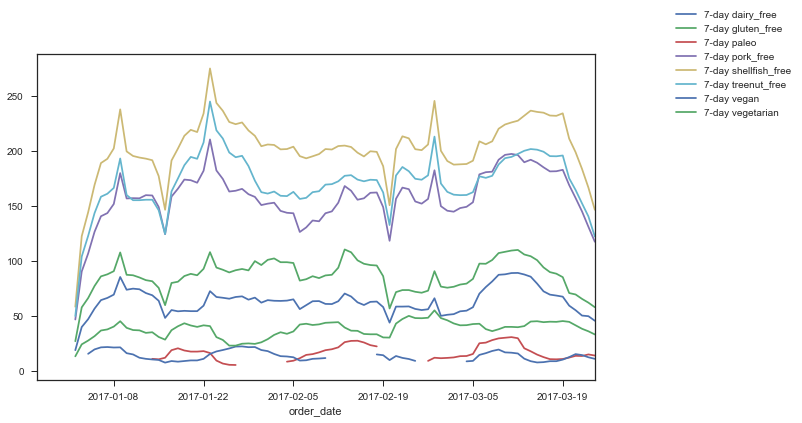

In [219]:
tags_plot = df.copy()
tags_plot['order_date'] = tags_plot['order_datetime'].apply(lambda x: x.date())
tags_plot = tags_plot.groupby(['order_date', 'value'])['order_id'].count()
tags_plot = tags_plot.unstack('value')
tags_list = list()

for col in tags_plot.columns:
    s = "7-day %s" % str(col)
    tags_plot[s] = tags_plot[col].rolling(window=7, center=False).mean()
    tags_list.append(s)

tags_plot[tags_list].plot()
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
tags_plot[['7-day dairy_free', '7-day gluten_free', 
          '7-day paleo', '7-day pork_free', '7-day shellfish_free',
          '7-day treenut_free', '7-day vegan', '7-day vegetarian']].plot()
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
print tags_list


It appears that the trends shown in tags ordered approximate the trends shown by orders overall. That says, to me, that user behavior with regard to tags is predictable, so dish suggestions made based on tags would make sense.

But let's get concrete evidence- just looking at a curve doesn't give solid information. I'll run a time series correlation for each of these series against the general purchasing series.

In [234]:
#little table for overall orders
df2 = df.copy()
df2['order_date'] = df['order_datetime'].apply(lambda x: x.date())
df2 = df2.groupby(['order_date'])['order_id'].count()
df2['7-day orders'] = df2.rolling(window=7, center=False).mean()

print "Dairy free", df2['7-day orders'].corr(tags_plot['7-day dairy_free'])
print "Gluten free", df2['7-day orders'].corr(tags_plot['7-day gluten_free'])
print "Pork free", df2['7-day orders'].corr(tags_plot['7-day pork_free'])
print "Shellfish free", df2['7-day orders'].corr(tags_plot['7-day shellfish_free'])
print "Treenut free", df2['7-day orders'].corr(tags_plot['7-day treenut_free'])
print "Vegan", df2['7-day orders'].corr(tags_plot['7-day vegan'])
print "Vegetarian", df2['7-day orders'].corr(tags_plot['7-day vegetarian'])
print "Paleo", df2['7-day orders'].corr(tags_plot['7-day paleo'])


Dairy free 0.765959742757
Gluten free 0.809603382141
Pork free 0.9626762247
Shellfish free 0.95748282491
Treenut free 0.946128454776
Vegan -0.0275123699764
Vegetarian 0.507871682601
Paleo 0.316453844931


Concretely, for the most part these dietary choices are strongly correlated with overall ordering behavior. The only ones that are not are the ones that are *actual choices,* i.e. Paleo, Vegan, and Vegetarian diets. Otherwise, it seems that those with food allergies are extremely likely to order dishes corresponding with their allergies almost all the time. This makes a good case for implementing allergy-based search optimization, though other dietary choices may be harder to predict.